In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.model_selection import TimeSeriesSplit, RandomizedSearchCV
from sklearn.compose import ColumnTransformer
from scipy.stats import uniform, randint
import xgboost as xgb
import matplotlib.pyplot as plt
import os
import joblib

# --- 1. Load Data ---

In [3]:
try:
    if 'final_df' not in locals():
        final_df = pd.read_csv('csv/f1_engineered_features.csv')
    print("Engineered data loaded successfully.")
    print(f"Shape: {final_df.shape}")
except FileNotFoundError:
    print("Error: 'csv/f1_engineered_features.csv' not found. Please run the feature engineering step first.")
except Exception as e:
    print(f"Error loading data: {e}")

Engineered data loaded successfully.
Shape: (2916, 29)


# --- 2. Define Features (X) and Target (y) ---

In [4]:
TARGET_COLUMN = 'FinalPoints'

identifier_cols = ['Season', 'Round', 'EventName', 'DriverId']
target_cols = ['FinalRank', 'FinalPoints']

feature_cols = [col for col in final_df.columns if col not in identifier_cols + target_cols]

X = final_df[feature_cols + ['Season']]
y = final_df[TARGET_COLUMN]

print(f"Target variable (y): {TARGET_COLUMN}")
print(f"Number of features (X): {len(feature_cols)}")
print(f"Feature columns: {feature_cols}")

Target variable (y): FinalPoints
Number of features (X): 23
Feature columns: ['TeamId', 'RaceCount', 'DidFinish', 'PitLaneStart', 'CumulativePoints', 'AvgPoints', 'AvgFinishPos', 'AvgGridPos', 'AvgPosGained', 'FinishRate', 'DNFCount', 'StdDevFinishPos', 'Wins', 'Podiums', 'Top10s', 'PointsLast5', 'AvgFinishLast5', 'AvgGridLast5', 'FinishRateLast5', 'DNFCountLast5', 'PrevSeasonRank', 'PrevSeasonPoints', 'PrevSeasonWins']


# --- 3. Chronological Split ---

In [5]:
X_train_raw = X.drop(columns=['Season'])
y_train = y

print(f"Training data shape (X): {X_train_raw.shape}, (y): {y_train.shape}")
print(f"Training seasons: {final_df['Season'].unique()}")

Training data shape (X): (2916, 23), (y): (2916,)
Training seasons: [2018 2019 2020 2021 2022 2023 2024]


# --- 4. Preprocessing Pipeline ---

In [6]:
categorical_features = ['TeamId']
numerical_features = [col for col in X_train_raw.columns if col not in categorical_features]

print(f"Categorical features: {categorical_features}")
print(f"Numerical features count: {len(numerical_features)}")

preprocessor = ColumnTransformer(
    transformers=[
        ('num', MinMaxScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_features)
    ],
    remainder='passthrough'
)

print("Fitting preprocessor on training data...")
preprocessor.fit(X_train_raw)

print("Transforming training and testing data...")
X_train_processed = preprocessor.transform(X_train_raw)

try:
    num_feature_names = numerical_features
    cat_feature_names = preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_features)
    processed_feature_names = num_feature_names + list(cat_feature_names)
    print(f"Total features after preprocessing: {len(processed_feature_names)}")
except Exception as e:
    processed_feature_names = None
    print(f"Could not retrieve feature names after preprocessing: {e}")


if processed_feature_names and len(processed_feature_names) == X_train_processed.shape[1]:
     X_train = pd.DataFrame(X_train_processed, columns=processed_feature_names, index=X_train_raw.index)
else:
     X_train = pd.DataFrame(X_train_processed, index=X_train_raw.index)
     print("Warning: Could not assign column names to processed DataFrames.")


print("\n--- Preprocessing Complete ---")
print("Sample of processed training data (X_train):")
print(X_train.head())
print("\nChecking range of scaled numerical features in X_train (should be ~0 to 1):")
print(X_train[numerical_features].describe().loc[['min', 'max']])

print("\nChecking for NaNs in processed data:")
print(f"NaNs in X_train: {X_train.isnull().sum().sum()}")
print(f"NaNs in y_train: {y_train.isnull().sum()}")

Categorical features: ['TeamId']
Numerical features count: 22
Fitting preprocessor on training data...
Transforming training and testing data...
Total features after preprocessing: 38

--- Preprocessing Complete ---
Sample of processed training data (X_train):
   RaceCount  DidFinish  PitLaneStart  CumulativePoints  AvgPoints  \
0        0.0        1.0           0.0               0.0        0.0   
1        0.0        1.0           0.0               0.0        0.0   
2        0.0        1.0           0.0               0.0        0.0   
3        0.0        0.0           0.0               0.0        0.0   
4        0.0        0.0           0.0               0.0        0.0   

   AvgFinishPos  AvgGridPos  AvgPosGained  FinishRate  DNFCount  ...  \
0      0.473684         0.5      0.529412         1.0       0.0  ...   
1      0.473684         0.5      0.529412         1.0       0.0  ...   
2      0.473684         0.5      0.529412         1.0       0.0  ...   
3      0.473684         0.5   

# --- 5. Initializing XGBoost Model ---

In [7]:
param_dist = {
    'learning_rate': uniform(0.01, 0.2),
    'max_depth': randint(3, 10),
    'subsample': uniform(0.6, 0.4),
    'colsample_bytree': uniform(0.6, 0.4),
    'gamma': uniform(0, 0.5),
    'min_child_weight': randint(1, 8),
    'reg_alpha': uniform(0, 1),
    'reg_lambda': uniform(0, 1),
}

In [8]:
n_training_seasons = final_df['Season'].nunique()
n_cv_splits = max(1, n_training_seasons - 1)

print(f"Number of training seasons: {n_training_seasons}")
print(f"Using n_splits={n_cv_splits} for TimeSeriesSplit.")

tscv = TimeSeriesSplit(n_splits=n_cv_splits)

Number of training seasons: 7
Using n_splits=6 for TimeSeriesSplit.


In [9]:
base_xgb = xgb.XGBRegressor(
    n_estimators=1500,
    random_state=68,
    n_jobs=-1,
    objective='reg:squarederror',
)

In [10]:
random_search = RandomizedSearchCV(
    estimator=base_xgb,
    param_distributions=param_dist,
    n_iter=50,
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    cv=tscv,
    verbose=2,
    random_state=68
)

In [11]:
random_search.fit(X_train, y_train)

Fitting 6 folds for each of 50 candidates, totalling 300 fits


RandomizedSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=6, test_size=None),
                   estimator=XGBRegressor(base_score=None, booster=None,
                                          callbacks=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None, device=None,
                                          early_stopping_rounds=None,
                                          enable_categorical=False,
                                          eval_metric=None, feature_types=None,
                                          feature_weights=None, gamm...
                                        'min_child_weight': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x000001F133B3DD10>,
                                        'reg_alpha': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x000001F133B64D60>,
                                        'reg_lambda': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x000001F133B5F410>,
                                        'subsample': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x000001F133B3E0D0>},
                   random_state=68, scoring='neg_mean_squared_error',
                   verbose=2)

In [12]:
print("Randomized Search CV complete.")
print(f"Best Score (Negative MSE): {random_search.best_score_}")
print("Best Parameters Found:")
print(random_search.best_params_)

best_xgb_model = random_search.best_estimator_

Randomized Search CV complete.
Best Score (Negative MSE): -2275.9062410728525
Best Parameters Found:
{'colsample_bytree': np.float64(0.6654918860157447), 'gamma': np.float64(0.43322900803234854), 'learning_rate': np.float64(0.03947912943239091), 'max_depth': 3, 'min_child_weight': 6, 'reg_alpha': np.float64(0.30917309319894537), 'reg_lambda': np.float64(0.3027904447124323), 'subsample': np.float64(0.6246573766584866)}


Top 20 Features:
                Feature  Importance
4             AvgPoints    0.342251
6            AvgGridPos    0.120383
5          AvgFinishPos    0.118545
11                 Wins    0.106152
30      TeamId_mercedes    0.034598
14          PointsLast5    0.029191
19       PrevSeasonRank    0.023119
20     PrevSeasonPoints    0.021528
21       PrevSeasonWins    0.021205
16         AvgGridLast5    0.019595
33      TeamId_red_bull    0.018021
12              Podiums    0.017979
22          TeamId_alfa    0.013479
28          TeamId_haas    0.009673
25  TeamId_aston_martin    0.009341
29       TeamId_mclaren    0.009161
37      TeamId_williams    0.009123
3      CumulativePoints    0.008167
7          AvgPosGained    0.007646
1             DidFinish    0.007126


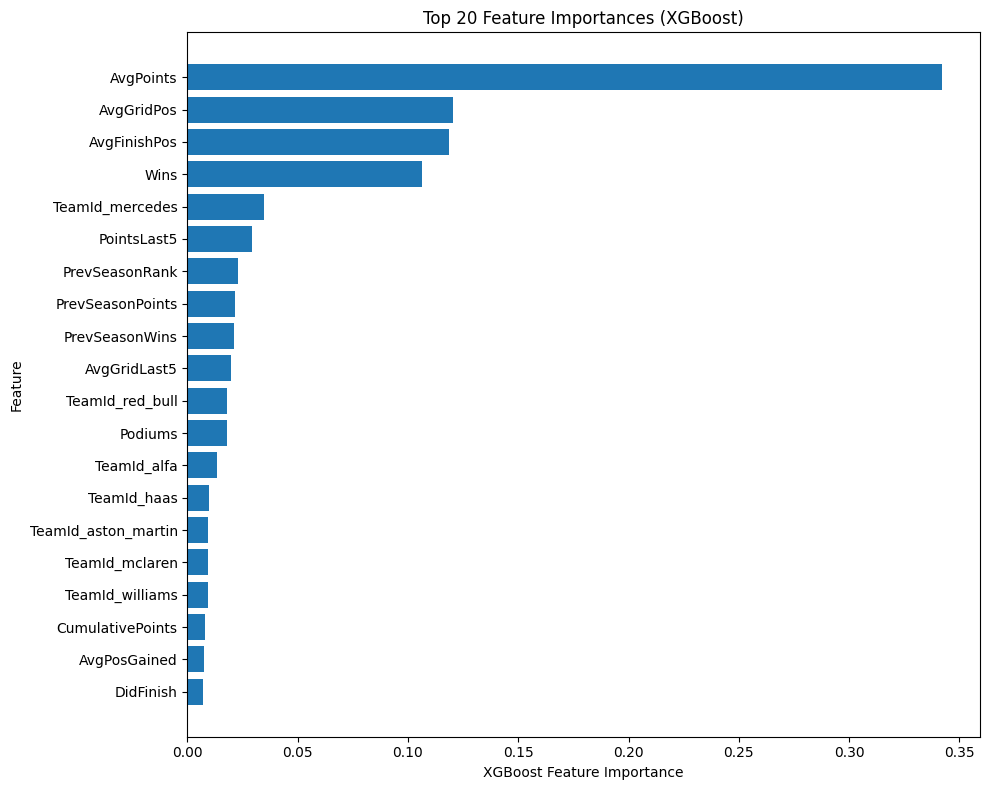

In [13]:
if 'processed_feature_names' in locals() and processed_feature_names is not None:
    try:
        importances = best_xgb_model.feature_importances_
        feature_importance_df = pd.DataFrame({
            'Feature': processed_feature_names,
            'Importance': importances
        }).sort_values(by='Importance', ascending=False)

        print("Top 20 Features:")
        print(feature_importance_df.head(20))

        plt.figure(figsize=(10, 8))
        plt.barh(feature_importance_df['Feature'][:20], feature_importance_df['Importance'][:20])
        plt.xlabel("XGBoost Feature Importance")
        plt.ylabel("Feature")
        plt.title("Top 20 Feature Importances (XGBoost)")
        plt.gca().invert_yaxis()
        plt.tight_layout()
        plt.show()
    except Exception as e:
        print(f"Could not generate feature importances plot: {e}")

else:
    print("Could not display feature importances because feature names were not available.")

# --- 11. Save model to a file ---

In [14]:
MODEL_ARTIFACTS_DIR = 'model_artifacts'
if not os.path.exists(MODEL_ARTIFACTS_DIR):
    os.makedirs(MODEL_ARTIFACTS_DIR)

try:
    model_path = os.path.join(MODEL_ARTIFACTS_DIR, 'trained_f1_model_xgb_final.joblib')
    joblib.dump(best_xgb_model, model_path)
    print(f"Trained model saved to: {model_path}")

    preprocessor_path = os.path.join(MODEL_ARTIFACTS_DIR, 'fitted_f1_preprocessor_xgb_final.joblib')
    joblib.dump(preprocessor, preprocessor_path)
    print(f"Fitted preprocessor saved to: {preprocessor_path}")

    if 'processed_feature_names' in locals() and processed_feature_names is not None:
        feature_names_path = os.path.join(MODEL_ARTIFACTS_DIR, 'processed_feature_names_xgb_final.joblib')
        joblib.dump(processed_feature_names, feature_names_path)
        print(f"Processed feature names saved to: {feature_names_path}")
    else:
        print("Warning: 'processed_feature_names' not found. Cannot save feature names.")
        print("Ensure this list is available from your preprocessing step (X_train.columns).")

    raw_feature_cols_for_prediction = X_train_raw.columns.tolist()
    raw_feature_names_path = os.path.join(MODEL_ARTIFACTS_DIR, 'raw_feature_cols_for_preprocessor_xgb_final.joblib')
    joblib.dump(raw_feature_cols_for_prediction, raw_feature_names_path)
    print(f"Raw feature columns for preprocessor input saved to: {raw_feature_names_path}")


except Exception as e:
    print(f"Error saving model artifacts: {e}")

Trained model saved to: model_artifacts\trained_f1_model_xgb_final.joblib
Fitted preprocessor saved to: model_artifacts\fitted_f1_preprocessor_xgb_final.joblib
Processed feature names saved to: model_artifacts\processed_feature_names_xgb_final.joblib
Raw feature columns for preprocessor input saved to: model_artifacts\raw_feature_cols_for_preprocessor_xgb_final.joblib
